In [1]:
!pip3 install --user findspark
import findspark
findspark.init()

In [2]:
import sparkmonitor
!jupyter nbextension install sparkmonitor --py --user --symlink 
!jupyter nbextension enable sparkmonitor --py --user            
!jupyter serverextension enable --py --user sparkmonitor
!ipython profile create && echo "c.InteractiveShellApp.extensions.append('sparkmonitor.kernelextension')" >>  $(ipython profile locate default)/ipython_kernel_config.py

Installing D:\Anaconda\lib\site-packages\sparkmonitor\static -> sparkmonitor
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable sparkmonitor --user --py
    
Enabling notebook extension sparkmonitor/module...
      - Validating: ok
Enabling: sparkmonitor.serverextension
- Writing config: C:\Users\aserg\.jupyter
    - Validating...
      sparkmonitor.serverextension  ok


In [3]:
#print(conf.toDebugString())

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    appName("DMF").\
    getOrCreate()

In [5]:
df1=spark.read.csv('DMF/DMF/ssdm1')
df2=spark.read.csv('DMF/DMF/ssdm2')
df3=spark.read.csv('DMF/DMF/ssdm3')
df=df1.union(df2).union(df3)

In [6]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, to_date

udf1 = udf(lambda x:x[0:1].strip(),StringType())
udf2 = udf(lambda x:x[1:10].strip(),StringType())
udf3 = udf(lambda x:x[10:30].strip(),StringType())
udf4 = udf(lambda x:x[30:34].strip(),StringType())
udf5 = udf(lambda x:x[34:49].strip(),StringType())
udf6 = udf(lambda x:x[49:64].strip(),StringType())
udf7 = udf(lambda x:x[64:65].strip(),StringType())
udf8 = udf(lambda x:x[65:73].strip(),StringType())
udf9 = udf(lambda x:x[73:81].strip(),StringType())

df=df.withColumn('transaction_type',udf1('_c0'))\
    .withColumn('security_number',udf2('_c0'))\
    .withColumn('last_name',udf3('_c0'))\
    .withColumn('name_suffix',udf4('_c0'))\
    .withColumn('first_name',udf5('_c0'))\
    .withColumn('middle_name',udf6('_c0'))\
    .withColumn('VP',udf7('_c0'))\
    .withColumn('death_date',to_date(udf8('_c0'),'MMddyyyy'))\
    .withColumn('birth_date',to_date(udf9('_c0'),'MMddyyyy'))\
    .drop('_c0')

In [7]:
df.show(10)

+----------------+---------------+---------+-----------+----------+-----------+---+----------+----------+
|transaction_type|security_number|last_name|name_suffix|first_name|middle_name| VP|death_date|birth_date|
+----------------+---------------+---------+-----------+----------+-----------+---+----------+----------+
|                |      001010001|   MUZZEY|           |     GRACE|           |   |      null|1902-04-16|
|                |      001010009|    SMITH|           |     ROGER|           |   |      null|1892-02-04|
|                |      001010010|  HAMMOND|           |   KENNETH|           |   |      null|1904-04-24|
|                |      001010011|     DREW|           |      LEON|          R|  V|1987-08-30|1908-06-14|
|                |      001010012|     CATE|           |     OLIVE|           |   |      null|1908-09-21|
|                |      001010013|   WHORFE|           |     FRANK|           |   |      null|1888-04-06|
|                |      001010015|     AMOS|  

In [9]:
df.select(df.transaction_type).distinct().count()


1

In [8]:
df=df.drop('transaction_type')

In [14]:
df.where("death_date is NULL").count() / rowCount

1.4213253235173514e-05

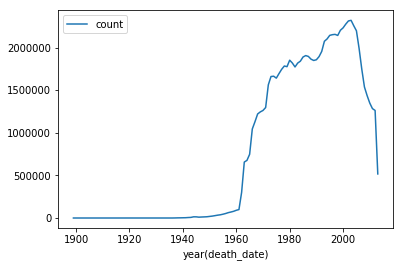

In [26]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year
df.groupBy(year(df.death_date)).count().orderBy('year(death_date)').toPandas().plot(x='year(death_date)',y='count')

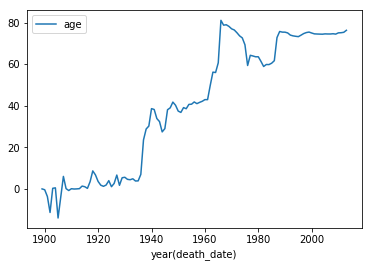

In [35]:
df.createOrReplaceTempView("DMF")
spark.sql("SELECT year(death_date),\
    avg(year(death_date)-year(birth_date)) as age\
    FROM DMF\
    GROUP BY year(death_date)\
    ORDER BY year(death_date)").toPandas()\
    .plot(x='year(death_date)',y='age')

In [31]:
df.groupBy(df.first_name).count().orderBy('count',ascending=False).limit(5).show()

+----------+-------+
|first_name|  count|
+----------+-------+
|      JOHN|2393041|
|      MARY|1985966|
|   WILLIAM|1970477|
|     JAMES|1749077|
|    ROBERT|1481577|
+----------+-------+



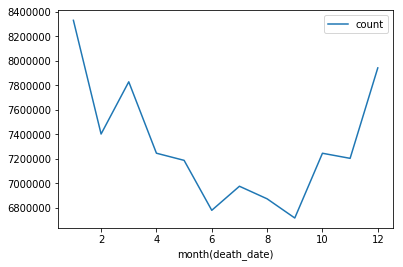

In [8]:
from pyspark.sql.functions import month
df.groupBy(month(df.death_date))\
    .count()\
    .orderBy('month(death_date)')\
    .toPandas()\
    .plot(x='month(death_date)',y='count')

In [9]:
from pyspark.sql.functions import month, when
df = df.withColumn(
    'season', 
        when(
            (month(df.death_date)==12) | (month(df.death_date)==1) | (month(df.death_date)==2),
            1
        ).when(
             (month(df.death_date)>2) & (month(df.death_date)<6),
            2
        ).when(
             (month(df.death_date)>5) & (month(df.death_date)<9),
            3
        ).when(
             (month(df.death_date)>8) & (month(df.death_date)<12),
            4  
        ))
df.show(10)

+---------------+---------+-----------+----------+-----------+---+----------+----------+------+
|security_number|last_name|name_suffix|first_name|middle_name| VP|death_date|birth_date|season|
+---------------+---------+-----------+----------+-----------+---+----------+----------+------+
|      001010001|   MUZZEY|           |     GRACE|           |   |      null|1902-04-16|  null|
|      001010009|    SMITH|           |     ROGER|           |   |      null|1892-02-04|  null|
|      001010010|  HAMMOND|           |   KENNETH|           |   |      null|1904-04-24|  null|
|      001010011|     DREW|           |      LEON|          R|  V|1987-08-30|1908-06-14|     3|
|      001010012|     CATE|           |     OLIVE|           |   |      null|1908-09-21|  null|
|      001010013|   WHORFE|           |     FRANK|           |   |      null|1888-04-06|  null|
|      001010015|     AMOS|           |   CHESTER|           |   |      null|1910-02-16|  null|
|      001010016|   KUNCHO|           | 

In [36]:
from pyspark.sql.functions import year
group_df = df.where(year(df.death_date)>1970).groupBy(df.season)\
    .count()\
    .orderBy('season')\
    .toPandas()

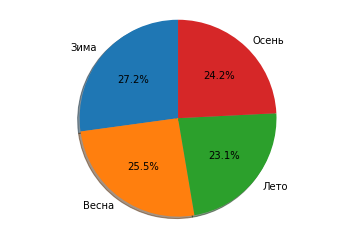

In [37]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes=group_df['count']
labels='Зима', 'Весна', 'Лето', 'Осень'
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [10]:
from pyspark.sql.functions import year
old_df = df.where((year(df.death_date)>1970) & (year(df.death_date)-year(df.birth_date)>50)).groupBy(df.season)\
    .count()\
    .orderBy('season')\
    .toPandas()

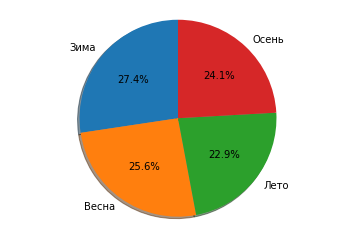

In [21]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes=old_df['count']
labels='Зима', 'Весна', 'Лето', 'Осень'
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [12]:
from pyspark.sql.functions import year
young_df = df.where((year(df.death_date)>1970) & (year(df.death_date)-year(df.birth_date)<30)).groupBy(df.season)\
    .count()\
    .orderBy('season')\
    .toPandas()

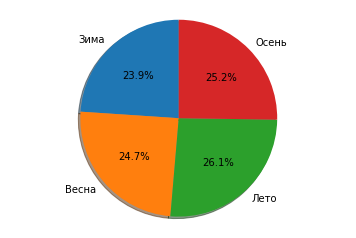

In [13]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes=young_df['count']
labels='Зима', 'Весна', 'Лето', 'Осень'
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [24]:
from pyspark.sql.functions import year  
year_df = df.where(year(df.death_date)>1970).groupBy([year(df.death_date), df.season])\
    .count()\
    .orderBy('year(death_date)')\
    .toPandas()

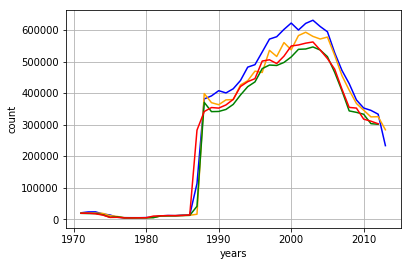

In [30]:
from pylab import *
 
years_winter = year_df[year_df.season==1]['year(death_date)']
years_spring = year_df[year_df.season==2]['year(death_date)']
years_summer = year_df[year_df.season==3]['year(death_date)']
years_autumn = year_df[year_df.season==4]['year(death_date)']
count_winter = year_df[year_df.season==1]['count']
count_spring = year_df[year_df.season==2]['count']
count_summer = year_df[year_df.season==3]['count']
count_autumn = year_df[year_df.season==4]['count']
plot(years_winter, count_winter, color="blue")
plot(years_spring, count_spring, color="orange")
plot(years_summer, count_summer, color="green")
plot(years_autumn, count_autumn, color="red")
xlabel('years')
ylabel('count')
grid(True)
show()

In [31]:
from pyspark.sql.functions import year  
year_old_df = df.where((year(df.death_date)>1970) & (year(df.death_date)-year(df.birth_date)>50)).groupBy([year(df.death_date), df.season])\
    .count()\
    .orderBy('year(death_date)')\
    .toPandas()

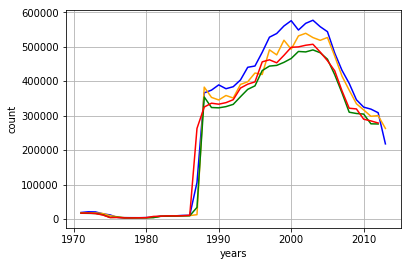

In [32]:
from pylab import *
 
years_winter = year_old_df[year_old_df.season==1]['year(death_date)']
years_spring = year_old_df[year_old_df.season==2]['year(death_date)']
years_summer = year_old_df[year_old_df.season==3]['year(death_date)']
years_autumn = year_old_df[year_old_df.season==4]['year(death_date)']
count_winter = year_old_df[year_old_df.season==1]['count']
count_spring = year_old_df[year_old_df.season==2]['count']
count_summer = year_old_df[year_old_df.season==3]['count']
count_autumn = year_old_df[year_old_df.season==4]['count']
plot(years_winter, count_winter, color="blue")
plot(years_spring, count_spring, color="orange")
plot(years_summer, count_summer, color="green")
plot(years_autumn, count_autumn, color="red")
xlabel('years')
ylabel('count')
grid(True)
show()

In [33]:
from pyspark.sql.functions import year  
year_young_df = df.where((year(df.death_date)>1970) & (year(df.death_date)-year(df.birth_date)<30)).groupBy([year(df.death_date), df.season])\
    .count()\
    .orderBy('year(death_date)')\
    .toPandas()

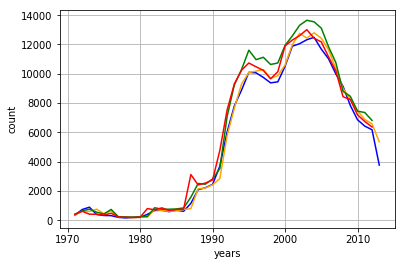

In [34]:
from pylab import *
 
years_winter = year_young_df[year_young_df.season==1]['year(death_date)']
years_spring = year_young_df[year_young_df.season==2]['year(death_date)']
years_summer = year_young_df[year_young_df.season==3]['year(death_date)']
years_autumn = year_young_df[year_young_df.season==4]['year(death_date)']
count_winter = year_young_df[year_young_df.season==1]['count']
count_spring = year_young_df[year_young_df.season==2]['count']
count_summer = year_young_df[year_young_df.season==3]['count']
count_autumn = year_young_df[year_young_df.season==4]['count']
plot(years_winter, count_winter, color="blue")
plot(years_spring, count_spring, color="orange")
plot(years_summer, count_summer, color="green")
plot(years_autumn, count_autumn, color="red")
xlabel('years')
ylabel('count')
grid(True)
show()